# 주제 : 베이커리 결제 데이터 분석

[ 목차 ]
1. 데이터 탐색
    - 데이터 확인

2. 데이터 전처리
    - 결측치 처리
    - 중복값 처리

3. 데이터 분석
    - 구매량, 시계열 분석
    - 장바구니 분석
    
4. 분석결과
    - 개요
    - 구매량, 시계열 분석
    - 장바구니 분석 - 상위 연관 규칙
    - 결론(마케팅 전략 제안)

---
---

## 1. 데이터 탐색

### 데이터 확인

- 기본 설정

In [1]:
# ▶ 한글 폰트 설정하기
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] =False

# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

In [64]:
# 필요한 라이브러리 호출
import os
import pandas as pd
import numpy as np
import seaborn as sns
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
import plotly.express as px


#### 데이터 설명

- 데이터 출처: [Kaggle](https://www.kaggle.com/datasets/akashdeepkuila/bakery/data) `Bakery Sales Dataset`

- 데이터 명세

| 컬럼명 | 설명          |
|-----|------------------|
|Transaction|거래 ID|
|Item|구매한 제품명|
|date_time|거래 날짜 및 시각|
|period_day|아침/오후/저녁/밤 중 언제 구매했는지 여부|
|weekday_weekend|주중/주말 중 언제 구매했는지 여부|

#### 데이터 프레임 생성

In [3]:
df = pd.read_csv("bakery_sales_revised.csv")
df.head()

,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,10/30/2016 9:58,morning,weekend
1,2,Scandinavian,10/30/2016 10:05,morning,weekend
2,2,Scandinavian,10/30/2016 10:05,morning,weekend
3,3,Hot chocolate,10/30/2016 10:07,morning,weekend
4,3,Jam,10/30/2016 10:07,morning,weekend


#### 데이터 정보 확인(info, 기술통계)

In [4]:
# 행, 열 개수 확인
df.shape

(20507, 5)

In [5]:
# 데이터 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Transaction      20507 non-null  int64 
 1   Item             20507 non-null  object
 2   date_time        20507 non-null  object
 3   period_day       20507 non-null  object
 4   weekday_weekend  20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB


- `Transaction`컬럼 제외 모두 명목형 변수다.
- `Transaction`컬럼도 거래 ID를 의미하므로 숫자지만 명목형 변수이다.

In [6]:
# 기술 통계량 확인
df.describe()

,Transaction
count,20507.000000
mean,4976.202370
std,2796.203001
min,1.000000
25%,2552.000000
50%,5137.000000
75%,7357.000000
max,9684.000000


- Transaction 컬럼은 거래 ID값이고, 나머지 컬럼도 명목형 변수이기 때문에 분포는 확인하지 않는다.

---

## 2. 데이터 전처리
- 본 분석에는 장바구니 분석을 통해 상품간의 연관성, 고객들의 구매 패턴을 파악하기 위한 분석이 포함되어 있으므로 FP-growth 알고리즘을 사용하기 위한 전처리는 장바구니 분석 파트에서 진행한다.
    - 고객 ID가 존재하지 않으므로 prefix 알고리즘 사용 불가
    - 따라서 연관 규칙 마이닝 알고리즘 중, 성능이 뛰어난 FP-growth 알고리즘을 사용한다.
- 모든 컬럼이 수치형 변수가 아닌 명목형 변수이므로, 이상값을 처리하지 않는다.

### 1) 결측치 처리

In [7]:
df.isna().sum()

Transaction        0
Item               0
date_time          0
period_day         0
weekday_weekend    0
dtype: int64

- 결측치 존재하지 않으므로 따로 처리하지 않는다.

### 2) 중복값 처리

In [8]:
# 중복데이터 확인
df.duplicated().sum()

np.int64(1620)

In [9]:
# 중복데이터 데이터 프레임으로 확인
df[df.duplicated()]

,Transaction,Item,date_time,period_day,weekday_weekend
2,2,Scandinavian,10/30/2016 10:05,morning,weekend
25,11,Bread,10/30/2016 10:27,morning,weekend
49,21,Coffee,10/30/2016 10:49,morning,weekend
101,49,Coffee,10/30/2016 12:23,afternoon,weekend
123,60,Coffee,10/30/2016 13:14,afternoon,weekend
...,...,...,...,...,...
20390,9618,Cake,4/8/2017 15:04,afternoon,weekend
20404,9627,Coffee,4/8/2017 16:05,afternoon,weekend
20423,9634,Coffee,4/8/2017 16:30,afternoon,weekend
20465,9664,Coffee,4/9/2017 11:40,morning,weekend


In [10]:
# 거래ID별 중복데이터 개수 확인
df[df.duplicated()]['Transaction'].value_counts()

Transaction
6290    5
6045    4
7245    4
6048    4
6730    3
       ..
3992    1
3984    1
3982    1
3969    1
9667    1
Name: count, Length: 1411, dtype: int64

In [11]:
# 중복 데이터 임의로 추출하여 확인하기
df[(df['Transaction']==6290)]

,Transaction,Item,date_time,period_day,weekday_weekend
12794,6290,Soup,2/9/2017 15:38,afternoon,weekday
12795,6290,Soup,2/9/2017 15:38,afternoon,weekday
12796,6290,Soup,2/9/2017 15:38,afternoon,weekday
12797,6290,Bread,2/9/2017 15:38,afternoon,weekday
12798,6290,Cake,2/9/2017 15:38,afternoon,weekday
12799,6290,Cake,2/9/2017 15:38,afternoon,weekday
12800,6290,Tea,2/9/2017 15:38,afternoon,weekday
12801,6290,Bread,2/9/2017 15:38,afternoon,weekday
12802,6290,Tea,2/9/2017 15:38,afternoon,weekday


- 동일한 거래ID(`Transaction`) 에 동일한 상품(`Item`)이 있는 경우는 한번 결제할 때, 동일한 상품을 여러개 구매한 경우로 간주하여 상품 구매 수량을 나타내는 `'Quantity'` 컬럼을 추가하여 중복값을 처리한다. 

In [12]:
# 동일한 거래 ID에 동일한 상품 개수 구하기
# 임의의 컬럼(date_time) 선정해 count하는 것에 사용
quantity_value = df.groupby(['Transaction','Item']).count()[['date_time']].sort_values(by='date_time',ascending=False).reset_index()
quantity_value = quantity_value.sort_values(by=['Transaction','Item']).reset_index(drop=True)
quantity_value

,Transaction,Item,date_time
0,1,Bread,1
1,2,Scandinavian,2
2,3,Cookies,1
3,3,Hot chocolate,1
4,3,Jam,1
...,...,...,...
18882,9682,Tacos-Fajita,1
18883,9682,Tea,1
18884,9683,Coffee,1
18885,9683,Pastry,1


In [13]:
# 값 1개 남기고 중복제거
preprocessed_df = df.drop_duplicates(keep='first')
preprocessed_df = preprocessed_df.sort_values(by=['Transaction','Item']).reset_index(drop=True)
preprocessed_df

,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,10/30/2016 9:58,morning,weekend
1,2,Scandinavian,10/30/2016 10:05,morning,weekend
2,3,Cookies,10/30/2016 10:07,morning,weekend
3,3,Hot chocolate,10/30/2016 10:07,morning,weekend
4,3,Jam,10/30/2016 10:07,morning,weekend
...,...,...,...,...,...
18882,9682,Tacos-Fajita,4/9/2017 14:32,afternoon,weekend
18883,9682,Tea,4/9/2017 14:32,afternoon,weekend
18884,9683,Coffee,4/9/2017 14:57,afternoon,weekend
18885,9683,Pastry,4/9/2017 14:57,afternoon,weekend


- 구메 수량 데이터 병합

In [14]:
# 위에서 구한 상품 개수 값을 데이터 프레임에 'Quantity' 컬럼으로 추가
preprocessed_df['Quantity'] = quantity_value['date_time']
preprocessed_df

,Transaction,Item,date_time,period_day,weekday_weekend,Quantity
0,1,Bread,10/30/2016 9:58,morning,weekend,1
1,2,Scandinavian,10/30/2016 10:05,morning,weekend,2
2,3,Cookies,10/30/2016 10:07,morning,weekend,1
3,3,Hot chocolate,10/30/2016 10:07,morning,weekend,1
4,3,Jam,10/30/2016 10:07,morning,weekend,1
...,...,...,...,...,...,...
18882,9682,Tacos-Fajita,4/9/2017 14:32,afternoon,weekend,1
18883,9682,Tea,4/9/2017 14:32,afternoon,weekend,1
18884,9683,Coffee,4/9/2017 14:57,afternoon,weekend,1
18885,9683,Pastry,4/9/2017 14:57,afternoon,weekend,1


- 구매 상품 수량 가장 많은 데이터 확인해서 구매 수량 데이터가 잘 병합 되었는지 확인

In [15]:
# 원본 데이터에서 구매 상품 수량 데이터 가장 많은 데이터 확인
quantity_value[quantity_value['date_time']==4]

,Transaction,Item,date_time
12457,6560,Coffee,4
13072,6850,Coffee,4
13170,6887,Coffee,4


In [16]:
# 중복값 제거 후 구매 상품 수량 추가해준 데이터에서 상품 구매 데이터 가장 많은 데이터 확인
preprocessed_df[preprocessed_df['Quantity']==4]

,Transaction,Item,date_time,period_day,weekday_weekend,Quantity
12457,6560,Coffee,2/14/2017 12:36,afternoon,weekday,4
13072,6850,Coffee,2/19/2017 11:46,morning,weekend,4
13170,6887,Coffee,2/19/2017 15:41,afternoon,weekend,4


In [17]:
preprocessed_df.shape

(18887, 6)

In [ ]:
preprocessed_df.head()

,Transaction,Item,date_time,period_day,weekday_weekend,Quantity
0,1,Bread,10/30/2016 9:58,morning,weekend,1
1,2,Scandinavian,10/30/2016 10:05,morning,weekend,2
2,3,Cookies,10/30/2016 10:07,morning,weekend,1
3,3,Hot chocolate,10/30/2016 10:07,morning,weekend,1
4,3,Jam,10/30/2016 10:07,morning,weekend,1


---

## 3. 데이터 분석

### 상품별 구매량, 구매 시간대 분석

#### 1) 구매량, 거래건수 TOP5 상품

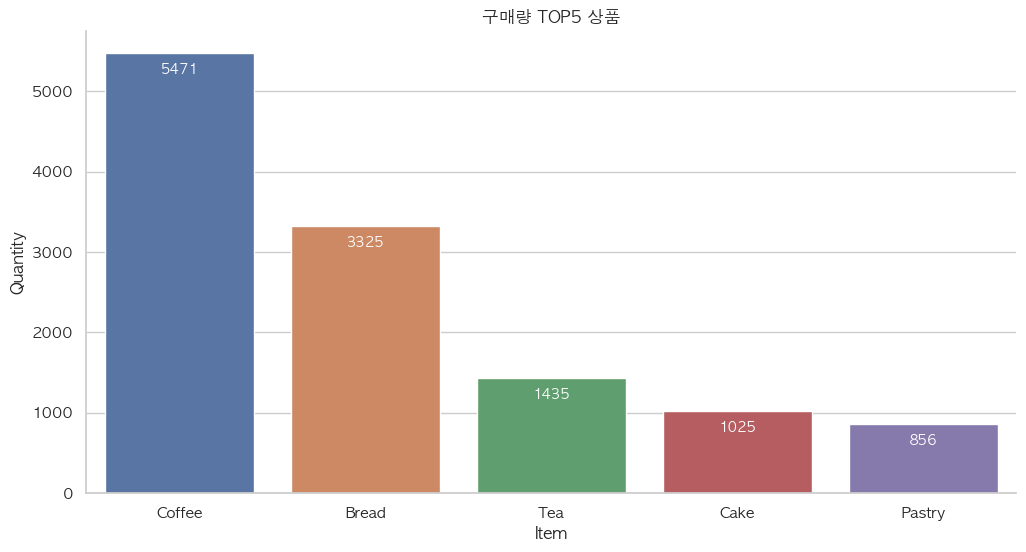

In [216]:
top_sales_df =  preprocessed_df.groupby('Item').sum('Quantity').reset_index()[['Item','Quantity']].sort_values(by='Quantity', ascending=False).head(5)
sns.set_theme(style='whitegrid',font='AppleGothic',rc={'figure.figsize':(12,6)})
ax = sns.barplot(data=top_sales_df, x="Item", y='Quantity', hue="Item")

# 텍스트 레이블 추가
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2, p.get_height()-120),  # 위치
                ha='center', va='top', fontsize=10, color='white', fontweight='bold')
plt.title("구매량 TOP5 상품")
sns.despine()
plt.show()

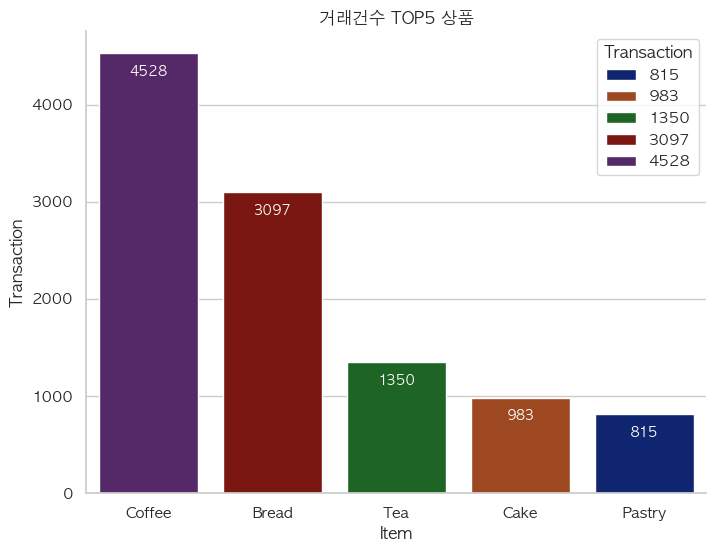

In [214]:
top_sales_df =  preprocessed_df.groupby('Item').count().reset_index()[['Item','Transaction']].sort_values(by='Transaction', ascending=False).head(5)

sns.set_theme(style='whitegrid',font='AppleGothic')
ax = sns.barplot(data=top_sales_df, x="Item", y='Transaction', hue="Transaction", palette='dark')

# 텍스트 레이블 추가
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2, p.get_height()-120),  # 위치
                ha='center', va='top', fontsize=10, color='white',fontweight='bold')
plt.title("거래건수 TOP5 상품")
sns.despine()
plt.show()

- 거래건수, 구매량 TOP10까지의 순위가 동일하다.
- 커피와 빵의 구매량이 상대적으로 매우 높다.

#### 2) 구매 시간대 분석

-  전체 상품 구매 시간대 분석

In [200]:
# date_time 컬럼값 datetime 포맷으로 변경
sales_time_df = preprocessed_df.copy()
sales_time_df['date_time'] = pd.to_datetime(preprocessed_df['date_time'])
sales_time_df

,Transaction,Item,date_time,period_day,weekday_weekend,Quantity
0,1,Bread,2016-10-30 09:58:00,morning,weekend,1
1,2,Scandinavian,2016-10-30 10:05:00,morning,weekend,2
2,3,Cookies,2016-10-30 10:07:00,morning,weekend,1
3,3,Hot chocolate,2016-10-30 10:07:00,morning,weekend,1
4,3,Jam,2016-10-30 10:07:00,morning,weekend,1
...,...,...,...,...,...,...
18882,9682,Tacos-Fajita,2017-04-09 14:32:00,afternoon,weekend,1
18883,9682,Tea,2017-04-09 14:32:00,afternoon,weekend,1
18884,9683,Coffee,2017-04-09 14:57:00,afternoon,weekend,1
18885,9683,Pastry,2017-04-09 14:57:00,afternoon,weekend,1


In [201]:
# 구매량 기준 주단위 시계열 데이터
quantity_time_df = sales_time_df.groupby(pd.Grouper(key="date_time", freq="H")).sum('Quantity')[['Quantity']].reset_index()

# 시간대 컬럼 생성
quantity_time_df['time'] = quantity_time_df['date_time'].dt.time

# 시간대로 그룹핑
quantity_hour_df = quantity_time_df.groupby('time').sum('Quantity').reset_index()
quantity_hour_df

,time,Quantity
0,00:00:00,0
1,01:00:00,1
2,02:00:00,0
3,03:00:00,0
4,04:00:00,0
5,05:00:00,0
6,06:00:00,0
7,07:00:00,24
8,08:00:00,645
9,09:00:00,1966


In [205]:
# 구매량 기준 시계열 데이터 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(8,6)})
fig = px.line(quantity_hour_df,x='time', y='Quantity', title='시간대별 전체 상품 구매량 변화 추이',
        hover_name='time', markers=True)

# x축과 y축 레이블 변경
fig.update_layout(
    xaxis_title="시간대",  
    yaxis_title="구매량",
    width=800,
    height=500
)

In [206]:
# 거래건수 기준 시간단위 시계열 데이터
transaction_time_df = sales_time_df.groupby(pd.Grouper(key="date_time", freq="H")).count()[['Transaction']].reset_index()
#transaction_time_df

# 시간대 컬럼 생성
transaction_time_df['time'] = transaction_time_df['date_time'].dt.time

# 시간대로 그룹핑
transaction_hour_df = transaction_time_df.groupby('time').sum('Transaction').reset_index()
transaction_hour_df

,time,Transaction
0,00:00:00,0
1,01:00:00,1
2,02:00:00,0
3,03:00:00,0
4,04:00:00,0
5,05:00:00,0
6,06:00:00,0
7,07:00:00,22
8,08:00:00,610
9,09:00:00,1820


In [207]:
# 판매량 기준 시계열 데이터 시각화
fig = px.line(transaction_hour_df, x=transaction_hour_df.index, y='Transaction', title='시간대별 거래건수 변화 추이',
        hover_name='Transaction', markers=True)

# x축과 y축 레이블 변경
fig.update_layout(
    xaxis_title="시간대",  
    yaxis_title="거래건수",
    width=800,
    height=500
)

- 판매량 TOP5 시계열 데이터

In [208]:
top_sales_df.head(5)['Item'].unique()

array(['Coffee', 'Bread', 'Tea', 'Cake', 'Pastry'], dtype=object)

In [209]:
# 판매량 TOP5 선별
sales_top5_q_time_df = sales_time_df[sales_time_df['Item'].isin(['Coffee', 'Bread', 'Tea', 'Cake', 'Pastry'])]

# 시간대를 0~23시로 변경
tmp = sales_top5_q_time_df.groupby(['Item',pd.Grouper(key="date_time", freq="H")]).sum('Quantity').reset_index()
tmp['time'] = tmp['date_time'].dt.time

# Item별로 그룹핑
sales_top5_q_hour_df = tmp.groupby(['Item','time']).sum('Quantity').reset_index()
sales_top5_q_hour_df

,Item,time,Transaction,Quantity
0,Bread,01:00:00,4090,1
1,Bread,07:00:00,2557,2
2,Bread,08:00:00,743956,171
3,Bread,09:00:00,1780019,400
4,Bread,10:00:00,2059775,508
...,...,...,...,...
57,Tea,15:00:00,1014304,207
58,Tea,16:00:00,592792,126
59,Tea,17:00:00,219608,41
60,Tea,18:00:00,14559,5


In [218]:
# 구매량 기준 시계열 데이터 시각화
fig = px.line(sales_top5_q_hour_df,x='time', y='Quantity', title='구매량 TOP5 상품 시간대별 구매량 변화 추이',
        hover_name='time', markers=True, color='Item')

# 그래프 디자인 세부 조정
fig.update_traces(hovertemplate=None)
fig.update_layout(
    xaxis_title="시간대",  
    yaxis_title="구매량",
    width=800,
    height=500,
    hovermode='x unified'
)
fig.show()

- 커피, 빵, 패스트리는 오전에 구매량이 높고 점차 감소한다.
- 케이크, 차는 오전보다 오후에 구매량이 높다.

### 장바구니 분석

#### 1) FP-growth 알고리즘 적용을 위한 전처리 작업
- 결제 건별로 데이터 그룹핑

- One-Hot 인코딩

In [19]:
# 결제 건별로 데이터 그룹핑
basket_df = preprocessed_df.groupby('Transaction')['Item'].agg(list).reset_index()
basket_df

,Transaction,Item
0,1,[Bread]
1,2,[Scandinavian]
2,3,"[Cookies, Hot chocolate, Jam]"
3,4,[Muffin]
4,5,"[Bread, Coffee, Pastry]"
...,...,...
9460,9680,[Bread]
9461,9681,"[Christmas common, Spanish Brunch, Tea, Truffles]"
9462,9682,"[Coffee, Muffin, Tacos-Fajita, Tea]"
9463,9683,"[Coffee, Pastry]"


In [20]:
# One-Hot Encoding
te = TransactionEncoder()
te_result = te.fit_transform(basket_df['Item'])

# DataFrame으로 변환
te_df = pd.DataFrame(te_result, columns=te.columns_)
te_df

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9460,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9461,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
9462,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9463,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### 2) 알고리즘 적용

In [21]:
frequent_itemsets = fpgrowth(te_df, min_support = .01, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.327205,(Bread)
1,0.029054,(Scandinavian)
2,0.058320,(Hot chocolate)
3,0.054411,(Cookies)
4,0.015003,(Jam)
...,...,...
56,0.019651,"(Brownie, Coffee)"
57,0.010777,"(Brownie, Bread)"
58,0.023666,"(Toast, Coffee)"
59,0.018067,"(Coffee, Scone)"


- 최소 지지도를 0.06으로 했을 때 7개의 빈발항목 밖에 남지 않아, 0.01로 조정

#### 3) 연관 규칙 추출 및 평가

In [22]:
rules_df = association_rules(frequent_itemsets, metric='confidence', min_threshold=.2)
rules_df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Bread),(Coffee),0.327205,0.478394,0.090016,0.275105,0.575059,-0.066517,0.719561,-0.523431
1,(Hot chocolate),(Coffee),0.058320,0.478394,0.029583,0.507246,1.060311,0.001683,1.058553,0.060403
2,(Hot chocolate),(Bread),0.058320,0.327205,0.013418,0.230072,0.703144,-0.005665,0.873841,-0.309550
3,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447,1.083723,0.002179,1.083174,0.081700
4,(Cookies),(Bread),0.054411,0.327205,0.014474,0.266019,0.813004,-0.003329,0.916638,-0.195651
5,(Muffin),(Coffee),0.038457,0.478394,0.018806,0.489011,1.022193,0.000408,1.020777,0.022579
6,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682,0.146161
7,(Pastry),(Bread),0.086107,0.327205,0.029160,0.338650,1.034977,0.000985,1.017305,0.036980
8,"(Pastry, Coffee)",(Bread),0.047544,0.327205,0.011199,0.235556,0.719901,-0.004357,0.880109,-0.290026
9,"(Pastry, Bread)",(Coffee),0.029160,0.478394,0.011199,0.384058,0.802807,-0.002751,0.846843,-0.201920


- 최소 신뢰도를 0.5로 엄격하게 설정해서 결과를 산출했더니 consequents가 모두 Coffee가 나왔다.

- 더 다양한 제품들의 연관성을 발견하기 위해 신뢰도를 0.2로 낮춰서 진행한다.

- 신뢰도를 낮추는 것을 보완하기 위해 아래와 같은 지표를 추가 활용한다.
    1. `lift` > 1: 두 항목이 서로 독립적이지 않고 실제로 연관이 있음을 의미
	2. `leverage` > 0: 발생 빈도가 우연의 일치보다 높음을 의미

In [23]:
# 분석할 규칙 선정(위 기준 적용)

# lift > 1 & leverage > 0 인 규칙 선별 후 향상도와 신뢰도로 내림차순 정렬
rules_top_df = rules_df[(rules_df['lift']>1)&(rules_df['leverage']>0)].sort_values(by=['lift','confidence'], ascending=False).reset_index(drop=True)
rules_top_df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(Tea, Coffee)",(Cake),0.049868,0.103856,0.010037,0.201271,1.937977,0.004858,1.121962,0.509401
1,(Cake),(Tea),0.103856,0.142631,0.023772,0.228891,1.604781,0.008959,1.111865,0.420538
2,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582,0.332006
3,(Sandwich),(Tea),0.071844,0.142631,0.014369,0.200000,1.402222,0.004122,1.071712,0.309050
4,(Spanish Brunch),(Coffee),0.018172,0.478394,0.010882,0.598837,1.251766,0.002189,1.300235,0.204851
5,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871,0.170091
6,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682,0.146161
7,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648,0.119574
8,(Juice),(Coffee),0.038563,0.478394,0.020602,0.534247,1.116750,0.002154,1.119919,0.108738
9,(Sandwich),(Coffee),0.071844,0.478394,0.038246,0.532353,1.112792,0.003877,1.115384,0.109205


#### 4) 선별 상품 추가 분석 진행
- 선별된 상품들이 판매되는 시간대에서 마케팅 전략 인사이트를 도출할 수 있을 것이라고 판단하여 판매 시간대 관련 추가 분석 진행
- 선별된 상품 외에 어떤 상품들이 판매되고 있는지 확인

In [33]:
tmp = preprocessed_df.groupby(['Item','period_day'])[['Transaction']].count().reset_index()
tmp[tmp['Item'].isin(['Cake','Tea','Sandwich','Toast','Spanish Brunch','Coffee'])]

,Item,period_day,Transaction
31,Cake,afternoon,696
32,Cake,evening,28
33,Cake,morning,259
48,Coffee,afternoon,2340
49,Coffee,evening,75
50,Coffee,morning,2113
169,Sandwich,afternoon,590
170,Sandwich,evening,4
171,Sandwich,morning,86
186,Spanish Brunch,afternoon,124


In [ ]:
# period_day 컬럼 고유값 확인
tmp['period_day'].unique()

array(['evening', 'afternoon', 'morning', 'night'], dtype=object)

In [ ]:
# 상품 종류 확인
df['Item'].unique()

array(['Bread', 'Scandinavian', 'Hot chocolate', 'Jam', 'Cookies',
       'Muffin', 'Coffee', 'Pastry', 'Medialuna', 'Tea', 'Tartine',
       'Basket', 'Mineral water', 'Farm House', 'Fudge', 'Juice',
       "Ella's Kitchen Pouches", 'Victorian Sponge', 'Frittata',
       'Hearty & Seasonal', 'Soup', 'Pick and Mix Bowls', 'Smoothies',
       'Cake', 'Mighty Protein', 'Chicken sand', 'Coke',
       'My-5 Fruit Shoot', 'Focaccia', 'Sandwich', 'Alfajores', 'Eggs',
       'Brownie', 'Dulce de Leche', 'Honey', 'The BART', 'Granola',
       'Fairy Doors', 'Empanadas', 'Keeping It Local', 'Art Tray',
       'Bowl Nic Pitt', 'Bread Pudding', 'Adjustment', 'Truffles',
       'Chimichurri Oil', 'Bacon', 'Spread', 'Kids biscuit', 'Siblings',
       'Caramel bites', 'Jammie Dodgers', 'Tiffin', 'Olum & polenta',
       'Polenta', 'The Nomad', 'Hack the stack', 'Bakewell',
       'Lemon and coconut', 'Toast', 'Scone', 'Crepes', 'Vegan mincepie',
       'Bare Popcorn', 'Muesli', 'Crisps', 'Pintxos', 

---

## 4. 분석 결과

#### 1) 개요

본 분석은 베이커리의 `매출 증대`와 `고객 만족도 향상`을 목적으로 고객의 결제 데이터를 분석하여 구매 패턴을 파악하고 예측하여 마케팅 전략 인사이트를 도출하기 위해 시행되었습니다. 본 보고서에서는 고객 구매 데이터를 기반으로 상품 구매량을 분석하고 시계열 데이터를 분석하여 매출을 증대시킬 수 있는 인사이트를 제공합니다. 또한 연관 규칙 마이닝의 결과로 특정 상품 조합이 선별된 이유와 상품 간의 연관성을 분석한 결과를 설명하고,  그에 기반한 매출 증대 및 고객 만족도 상승을 위한 인사이트를 제안합니다. 연관 규칙 마이닝은 향상도와 신뢰도 기준 TOP5 상품 조합 중점으로 결과를 설명하겠습니다.

#### 2) 구매량, 시계열 분석

- 커피와 빵이 구매량 TOP10 상품의 총 구매량 중 약 60%를 차지한다.
    - 별다른 프로모션 없이도 안정적인 매출
    - 매출 볼륨을 이끄는 상품
- 차, 케이크, 페스트리는 구매량 TOP10 상품의 총 구매량 증 23% 차지한다.
    - 커피와 빵보다는 아니지만 안정적인 매출에 기여하는 상품
    - 해당 상품은 프로모션으로 매출 볼륨이 증가할 가능성이 높다.
- 커피, 빵, 패스트리는 오전에 구매량이 높고 점차 감소한다. 

- 케이크, 차는 오전보다 오후에 구매량이 높다.

#### 3) 장바구니 분석 - 상위 연관 규칙
[상품 조합]
1. '커피와 차'와 '케이크'
2. '케이크'와 '차'
3. '토스트'와 '커피'
4. '샌드위치'와 '차'
5. '스페인식 브런치'와 '커피'
 
[인사이트]
- `lift > 1 & leverage > 0` 를 기준으로 선별한 상품 조합을 전체적으로 분석했을 때, 대부분의 베이커리 상품과 '커피'가 연관되어 있다는 사실을 알 수 있다.
- 디저트 중에서 '케이크'가 가장 '커피'와 연관성이 높다.
- 간편식 중에서 '샌드위치'가 가장 '차'와 연관성이 높다.
- 간편식 중에서 '토스트'가 가장 '커피'와 연관성이 높다.
- 식사류 중에서 '스페인식 브런치'와 '커피'와 연관성이 높다.

#### 4) 결론(마케팅 전략 제안)

1. 식사 - 디저트 - 음료 세트 상품 출시
    - '스페인식 브런치'와 '케이크' 모두 '커피'와 연관성이 높으므로 ['스페인식 브런치' - '케이크' - '커피'] 세트 상품 출시
    - '스페인식 브런치', '케이크', '커피' 모두 오후(afternoon)에 판매가 많이 되므로 오후 시간에는 시간 한정 할인 이벤트를 진행해보면 좋을 것 같다.
    - 구매 니즈 측면에서 연관성이 높은 상품끼리 묶여 세트 상품이 출시되므로 매출 증대와 더불어 고객의 만족도도 상승할 것이라고 기대된다.

2. 베이커리 구매시 커피 할인 프로모션 진행
    - TOP5 외에도 기준에 의해 선별된 규칙을 분석해보면 대부분의 베이커리 상품이 '커피'와 연관성이 높다.
    - 따라서 베이커리와 커피를 엮어 프로모션을 진행하면 매출 증대에 기여할 것으로 보인다.

3. '케이크' 혹은 '샌드위치' 2개 이상 구매시 티백 증정 이벤트
    - '케이크', '샌드위치' 모두 '차'와 연관성이 높다.
    - 따라서 '케이크' 혹은 '샌드위치'를 구매할 때, 판매하는 차의 티백을 증정하는 이벤트를 진행한다면 '케이크', '샌드위치'의 매출이 증대될 것이라 기대된다.

4. 런치 디저트 세트 출시 및 프로모션('케이크' & '차')
    - '케이크'와 '차'는 연관성도 높고 둘다 점심 직후인 13시부터 구매량이 증가한다.
    - 따라서 점심 직후 시간대를 타겟하여 13시~15시에 런치 디저트 세트 프로모션 진행하면 매출이 증대될 것이다.